## Background

In the fastai course Part 1 [Lesson 6 video](https://youtu.be/AdhG64NF76E?feature=shared&t=3117) Jeremy Howard walked through the notebooks [First Steps: Road to the Top, Part 1](https://www.kaggle.com/code/jhoward/first-steps-road-to-the-top-part-1) and [Small models: Road to the Top, Part 2](https://www.kaggle.com/code/jhoward/small-models-road-to-the-top-part-2) where he builds increasingly accurate solutions to the [Paddy Doctor: Paddy Disease Classification](https://www.kaggle.com/competitions/paddy-disease-classification) Kaggle Competition. In the video, Jeremy referenced a series of walkthrough videos that he made while working through the four-notebook series for this competition. I'm excited to watch these walkthroughs to better understand how to approach a Kaggle competition from the perspective of a former #1 Kaggle grandmaster.

In this blog post series, I'll walk through the code Jeremy shared in each of the 6 Live Coding videos focused on this competition, submitting predictions to Kaggle along the way. My last two blog posts in this series reference Jeremy's [Scaling Up: Road to the Top, Part 3](https://www.kaggle.com/code/jhoward/scaling-up-road-to-the-top-part-3) notebook to improve my large model ensemble predictions. Here are the links to each of the blog posts in this series:

- [Part 1: Live Coding 8](https://vishalbakshi.github.io/blog/posts/2024-02-05-paddy-part-1/)
- [Part 2: Live Coding 9](https://vishalbakshi.github.io/blog/posts/2024-02-05-paddy-part-2/)
- [Part 3: Live Coding 10](https://vishalbakshi.github.io/blog/posts/2024-02-05-paddy-part-3/)
- [Part 4: Live Coding 11](https://vishalbakshi.github.io/blog/posts/2024-02-05-paddy-part-4/)
- [Part 5: Live Coding 12](https://vishalbakshi.github.io/blog/posts/2024-02-05-paddy-part-5/)
- Part 6: Live Coding 13 (You are here)
- [Part 7: Improving My Large Ensemble, Part 1](https://vishalbakshi.github.io/blog/posts/2024-02-05-paddy-part-7/)
- [Part 8: Improving My Large Ensemble, Part 2](https://vishalbakshi.github.io/blog/posts/2024-02-05-paddy-part-8/)


[Link to Live Coding 13](https://www.youtube.com/watch?v=INrkhUGCXHg)

### Loading the Data

In [2]:
!pip install -qq timm==0.6.13
import timm
timm.__version__

'0.6.13'

In [3]:
# install fastkaggle if not available
try: import fastkaggle
except ModuleNotFoundError:
    !pip install -Uq fastkaggle

from fastkaggle import *
from fastai.vision.all import *

comp = 'paddy-disease-classification'
path = setup_comp(comp, install='fastai')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
path.ls()

(#4) [Path('../input/paddy-disease-classification/sample_submission.csv'),Path('../input/paddy-disease-classification/train_images'),Path('../input/paddy-disease-classification/train.csv'),Path('../input/paddy-disease-classification/test_images')]

In [5]:
trn_path = path/'train_images'

### Multi-Task Classification

Jeremy re-did his approach to the multi-head (multi-task) classification that we started in the last live coding session. Spoiler alert: it didn't turn out to help our final score, the score was about the same. As soon as Jeremy turned off Zoom and went for a walk, he realized how he should approach this problem. We can make this much much simpler.

We are going to try to predict two things: the disease and the variety for each image. The first thing is to create a pair of `DataLoaders`:

In [6]:
df = pd.read_csv(path/'train.csv')
df.head()

image_id                  label variety  age
0  100330.jpg  bacterial_leaf_blight   ADT45   45
1  100365.jpg  bacterial_leaf_blight   ADT45   45
2  100382.jpg  bacterial_leaf_blight   ADT45   45
3  100632.jpg  bacterial_leaf_blight   ADT45   45
4  101918.jpg  bacterial_leaf_blight   ADT45   45

### Converting `ImageDataLoaders` to `DataBlock`

Recreate what we had starting from the small models where Jeremy used `ImageDataLoaders` which is the highest-level, least-flexible function where you can do all of the data processing in a single line of code but only if we want to do something really standard. Trying to predict two things is not standard enough for it. 

We need to go one layer down. All of the work in `ImageDataLoaders` is being done by `DataBlock`, which is still high-level API but very flexible.

Here's how to setup a `DataBlock` for disease classification:

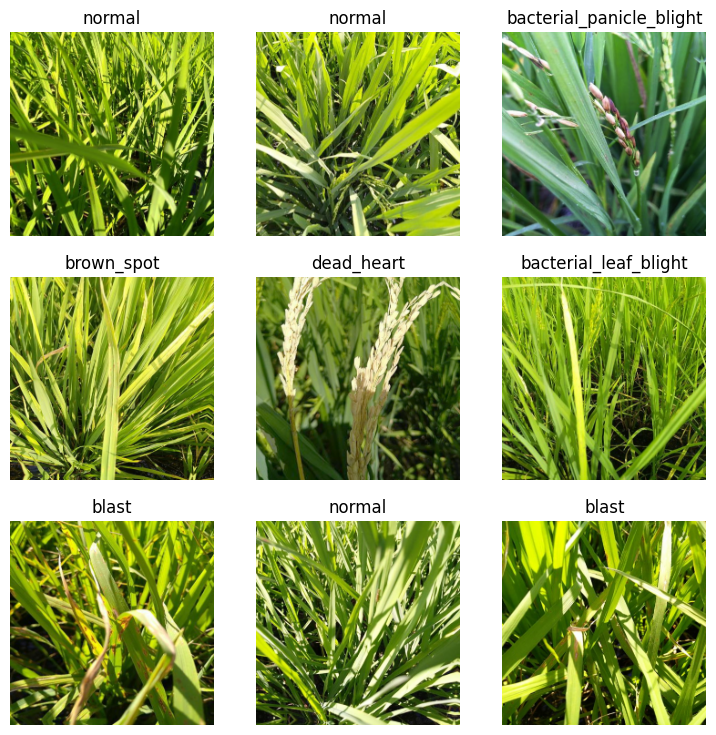

In [21]:
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items = get_image_files,
    get_y = parent_label,
    splitter=RandomSplitter(0.2, seed=42),
    item_tfms=Resize(480, method='squish'),
    batch_tfms=aug_transforms(size=224, min_scale=0.75))

dls = dblock.dataloaders(trn_path)
dls.show_batch()

Here's the source code of `ImageBlock`:

```python
def ImageBlock(cls:PILBase=PILImage):
    "A `TransformBlock` for images of `cls`"
    return TransformBlock(type_tfms=cls.create, batch_tfms=IntToFloatTensor)
```

Which calls `PILImage.create`, which returns an Image from a filename:

In [22]:
PILImage.create?

Signature:
PILImage.create(
    fn: 'Path | str | Tensor | ndarray | bytes | Image.Image',
    **kwargs,
)
Docstring: Return an Image from `fn`
File:      /opt/conda/lib/python3.10/site-packages/fastai/vision/core.py
Type:      method

`get_image_files` will return a list of `Path`s:

In [23]:
get_image_files(trn_path)

(#10407) [Path('../input/paddy-disease-classification/train_images/tungro/109629.jpg'),Path('../input/paddy-disease-classification/train_images/tungro/104765.jpg'),Path('../input/paddy-disease-classification/train_images/tungro/109706.jpg'),Path('../input/paddy-disease-classification/train_images/tungro/100098.jpg'),Path('../input/paddy-disease-classification/train_images/tungro/102734.jpg'),Path('../input/paddy-disease-classification/train_images/tungro/106433.jpg'),Path('../input/paddy-disease-classification/train_images/tungro/108930.jpg'),Path('../input/paddy-disease-classification/train_images/tungro/102019.jpg'),Path('../input/paddy-disease-classification/train_images/tungro/102416.jpg'),Path('../input/paddy-disease-classification/train_images/tungro/101046.jpg')...]

These `Path`s are passed into `PILImage.create` to create an image:

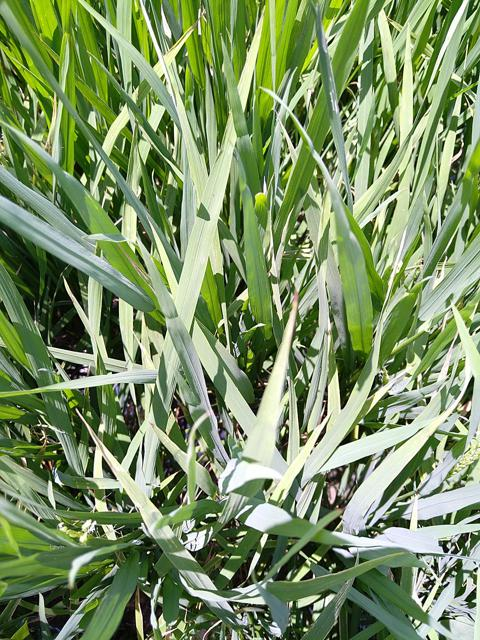

In [25]:
PILImage.create(get_image_files(trn_path)[0])

We have now just replicated what is happening in the code with `ImageBlock` (which also converts the `PILImage` object into a tensor with `IntToFloatTensor`).

Jeremy then made sure that the `DataBlock` approach to create the `DataLoaders` resulted in a successful training run, making sure to use a very small model and small image size to make it run quickly (as all we're testing is that it trains it correctly).

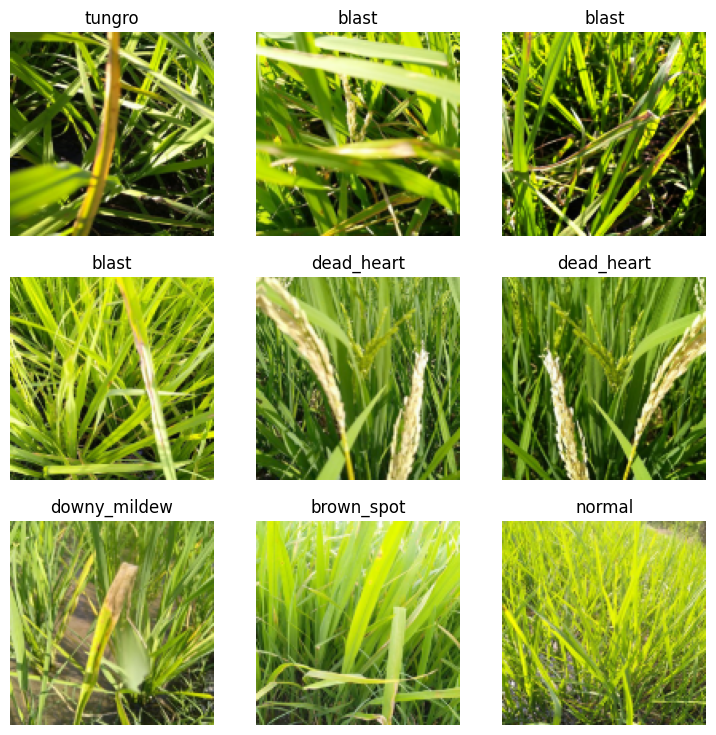

In [26]:
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items = get_image_files,
    get_y = parent_label,
    splitter=RandomSplitter(0.2, seed=42),
    item_tfms=Resize(480, method='squish'),
    batch_tfms=aug_transforms(size=128, min_scale=0.75))

dls = dblock.dataloaders(trn_path)
dls.show_batch()

In [27]:
learn = vision_learner(dls, resnet18, metrics=error_rate).to_fp16()
learn.fit_one_cycle(1, 0.01)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth

100%|██████████| 44.7M/44.7M [00:00<00:00, 52.0MB/s]


You want something that works this quickly so that you can test that end-to-end things are working.

Note: fastai will shuffle the training dataset before each epoch to ensure the model is trained on a different order of images each epoch.

Then, Jeremy ran the training run on the same architecture and number of epochs as before to make sure he got the same error rate:

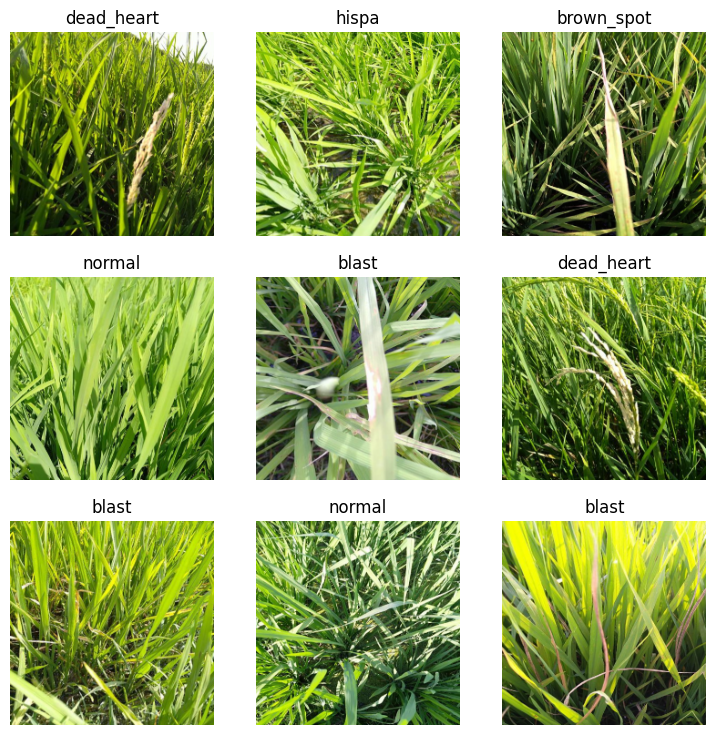

In [5]:
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items = get_image_files,
    get_y = parent_label,
    splitter=RandomSplitter(0.2, seed=42),
    item_tfms=Resize(480, method='squish'),
    batch_tfms=aug_transforms(size=224, min_scale=0.75))

dls = dblock.dataloaders(trn_path)
dls.show_batch()

In [7]:
learn = vision_learner(dls, 'convnext_small_in22k', metrics=error_rate).to_fp16()
learn.fine_tune(12, 0.01)

The final error rate (~0.02) is similar to the original training done using the `DataLoaders` made from `ImageDataLoaders`.

### Make `DataBlock` Spit Out Three Things

One image and two categories (disease and variety). To get it to spit out two categories, you add another `CategoryBlock`.

Given an image id we need a way of getting its `variety`. Originally Jeremy handled it with "an ugly way" of doing it. Instead create a `dict` which maps from `image_id` to `variety`, and our function will be to just look that up.



In [8]:
img2variety = { r.image_id: r.variety for _, r in df.iterrows() }

In [9]:
dict(list(img2variety.items())[0:10])

{'100330.jpg': 'ADT45',
 '100365.jpg': 'ADT45',
 '100382.jpg': 'ADT45',
 '100632.jpg': 'ADT45',
 '101918.jpg': 'ADT45',
 '102353.jpg': 'ADT45',
 '102848.jpg': 'ADT45',
 '103051.jpg': 'ADT45',
 '103702.jpg': 'ADT45',
 '103920.jpg': 'ADT45'}

When you access a `dict` item, like `img2variety['100330.jpg']`, behind the scenes it's making a function call `img2variety.__getitem__('100330.jpg')`

In [13]:
img2variety.__getitem__('100330.jpg')

'ADT45'

However, in the `DataBlock`, `get_image_files` returns a bunch of `Path` objects which get passed to the `get_y` function to get the dependent variables. Since `img2variety` keys are filename strings, we need to wrap it in a function to handle `Path` object inputs:

In [9]:
def get_variety(p): return img2variety[p.name]

We need to tell the `DataBlock` how many of the `blocks` are independent variables with `n_inp`.

In [15]:
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock, CategoryBlock),
    n_inp=1,
    get_items=get_image_files,
    get_y = [parent_label, get_variety],
    splitter=RandomSplitter(0.2, seed=42),
    item_tfms=Resize(480, method='squish'),
    batch_tfms=aug_transforms(size=224, min_scale=0.75))

Before creating `DataLoaders`, test with `Datasets` as they are easier to debug (can access one image at a time instead of a batch).

In [16]:
dss = dblock.datasets(trn_path)

In [17]:
img, y1, y2 = dss.train[0]

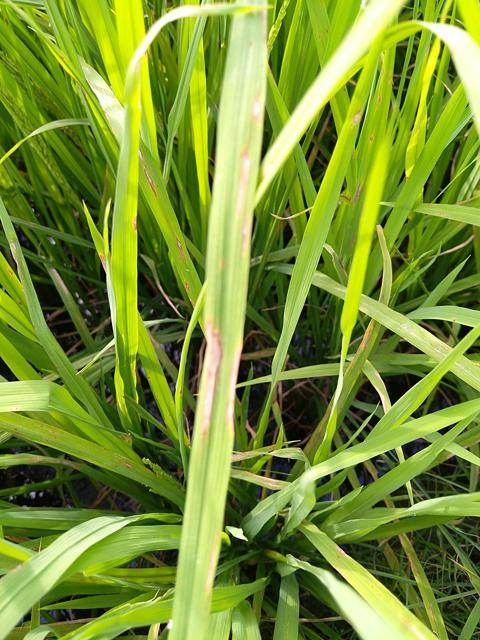

In [18]:
img

In [19]:
y1

TensorCategory(3)

In [20]:
y2

TensorCategory(0)

Let's recreate the pipeline of going from filename to these three outputs:

In [21]:
fn = get_image_files(trn_path)[0]

In [27]:
fn, fn.name

(Path('../input/paddy-disease-classification/train_images/tungro/109629.jpg'),
 '109629.jpg')

Recreating what the `ImageBlock` does:

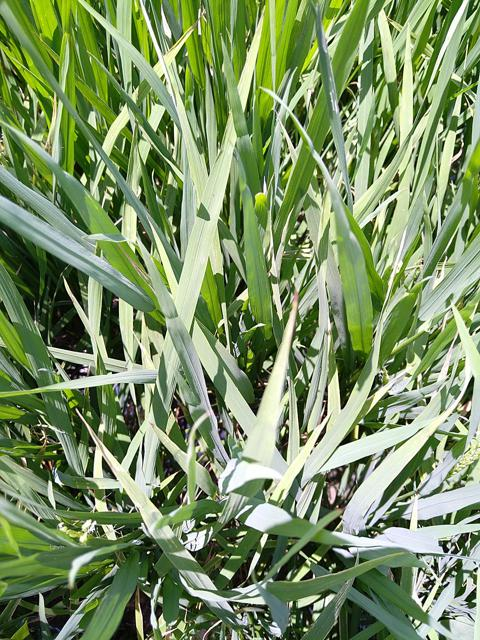

In [23]:
PILImage.create(fn)

Recreating what `get_y` does:

In [26]:
[parent_label(fn), get_variety(fn)]

['tungro', 'ADT45']

Would it make sense to have multiple `get_items`? No, `get_items` returns a single thing, but it could be whatever you like (`tuple`, `list`, `dict`, etc.). Then `get_y` and `get_x` are responsible for pulling out the bit that you need to pass to your `blocks`. We don't need `get_x` in this case because `ImageBlock`s just take `Path`s as inputs directly.

Here is the "hacky" method Jeremy tried originally:


```python
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock, CategoryBlock),
    n_inp=1,
    get_x = lambda x: trn_path/x[1]/x[0],
    get_y = [ColReader(1), ColReader(2)],
    splitter=RandomSplitter(0.2, seed=42),
    item_tfms=Resize(480, method='squish'),
    batch_tfms=aug_transforms(size=224, min_scale=0.75))
```

### How does `TransformBlock` and `ImageBlock` work

Now we'll go into the weeds.

In [5]:
TransformBlock??

Init signature:
TransformBlock(
    type_tfms: 'list' = None,
    item_tfms: 'list' = None,
    batch_tfms: 'list' = None,
    dl_type: 'TfmdDL' = None,
    dls_kwargs: 'dict' = None,
)
Source:        
class TransformBlock():
    "A basic wrapper that links defaults transforms for the data block API"
    def __init__(self, 
        type_tfms:list=None, # One or more `Transform`s
        item_tfms:list=None, # `ItemTransform`s, applied on an item
        batch_tfms:list=None, # `Transform`s or `RandTransform`s, applied by batch
        dl_type:TfmdDL=None, # Task specific `TfmdDL`, defaults to `TfmdDL`
        dls_kwargs:dict=None, # Additional arguments to be passed to `DataLoaders`
    ):
        self.type_tfms  =            L(type_tfms)
        self.item_tfms  = ToTensor + L(item_tfms)
        self.batch_tfms =            L(batch_tfms)
        self.dl_type,self.dls_kwargs = dl_type,({} if dls_kwargs is None else dls_kwargs)
File:           /opt/conda/lib/python3.10/site-packages/fast

A `TransformBlock` stores a bunch of things you pass in, like type transforms, item transforms, batch transforms, it always adds `ToTensor` since PyTorch works with tensors. Remember that an `ImageBlock` is a `TransformBlock` where the type transform is specified as `PILImage.create` and the batch transform is `IntToTensor`.

If you pass `TransformBlock` to the `DataBlock.blocks`, it wont do anything.

In [6]:
dblock = DataBlock(
    blocks=(TransformBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(0.2, seed=42),
)

In [7]:
dss = dblock.datasets(trn_path)

In [8]:
dss.train[0]

(Path('../input/paddy-disease-classification/train_images/blast/105663.jpg'),)

All this does is take the output of `get_image_files[0]` and turns it into a tuple containing one thing, which is the thing itself. If we have two transform blocks, it returns a tuple with two things in it:

In [10]:
dblock = DataBlock(
    blocks=(TransformBlock, TransformBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(0.2, seed=42),
)

dss = dblock.datasets(trn_path)
dss.train[0]

(Path('../input/paddy-disease-classification/train_images/blast/105663.jpg'),
 Path('../input/paddy-disease-classification/train_images/blast/105663.jpg'))

It's returning tuples because that's what we want: we want batches of tuples that contain inputs and outputs (potentially multiple inputs and outputs).

We can do stuff to the first thing in the tuple with `get_x`:

In [11]:
dblock = DataBlock(
    blocks=(TransformBlock, TransformBlock),
    get_x=lambda o: o.name,
    get_items=get_image_files,
    splitter=RandomSplitter(0.2, seed=42),
)

dss = dblock.datasets(trn_path)
dss.train[0]

('105663.jpg',
 Path('../input/paddy-disease-classification/train_images/blast/105663.jpg'))

`o.name` for each `get_image_files` output is the filename. We can do stuff to the second thing in the tuple with `get_y`:

In [12]:
dblock = DataBlock(
    blocks=(TransformBlock, TransformBlock),
    get_x=lambda o: o.name,
    get_y=lambda o: o.parent,
    get_items=get_image_files,
    splitter=RandomSplitter(0.2, seed=42),
)

dss = dblock.datasets(trn_path)
dss.train[0]

('105663.jpg',
 Path('../input/paddy-disease-classification/train_images/blast'))

`TransformBlock`s don't do anything but the number of them you have is the number of pipelines it's going to create. Suppose we had three `TransformBlock`s assigned to `DataBlock.blocks`---this will require a total of three functions between `get_x` and `get_y`:

In [13]:
dblock = DataBlock(
    blocks=(TransformBlock, TransformBlock, TransformBlock),
    get_x=[lambda o: o.name, lambda o: o.name],
    get_y=lambda o: o.parent,
    get_items=get_image_files,
    splitter=RandomSplitter(0.2, seed=42),
)

dss = dblock.datasets(trn_path)
dss.train[0]

('105663.jpg',
 '105663.jpg',
 Path('../input/paddy-disease-classification/train_images/blast'))

By default, the last one in the tuple is the `y` and the first two are the `x`, unless we specify `n_inp` as `1`, provide 1 function for `get_x` and then two functions for `get_y`:

In [17]:
dblock = DataBlock(
    blocks=(TransformBlock, TransformBlock, TransformBlock),
    n_inp=1,
    get_x=lambda o: o.name,
    get_y=[lambda o: o.parent, lambda o: o.parent],
    get_items=get_image_files,
    splitter=RandomSplitter(0.2, seed=42),
)

dss = dblock.datasets(trn_path)
dss.train[0]

('105663.jpg',
 Path('../input/paddy-disease-classification/train_images/blast'),
 Path('../input/paddy-disease-classification/train_images/blast'))

You can also pass the functions to `TransformBlock.type_tfms` instead:

In [19]:
dblock = DataBlock(
    blocks=(TransformBlock(type_tfms=[lambda o: o.name]), TransformBlock, TransformBlock),
    n_inp=1,
    get_y=[lambda o: o.parent, lambda o: o.parent],
    get_items=get_image_files,
    splitter=RandomSplitter(0.2, seed=42),
)

dss = dblock.datasets(trn_path)
dss.train[0]

('105663.jpg',
 Path('../input/paddy-disease-classification/train_images/blast'),
 Path('../input/paddy-disease-classification/train_images/blast'))

Let's create an `ImageBlock` manually:

In [22]:
dblock = DataBlock(
    blocks=(TransformBlock(type_tfms=PILImage.create, batch_tfms=IntToFloatTensor), TransformBlock, TransformBlock),
    n_inp=1,
    get_y=[lambda o: o.parent, lambda o: o.parent],
    get_items=get_image_files,
    splitter=RandomSplitter(0.2, seed=42),
)

dss = dblock.datasets(trn_path)
dss.train[0]

(PILImage mode=RGB size=480x640,
 Path('../input/paddy-disease-classification/train_images/blast'),
 Path('../input/paddy-disease-classification/train_images/blast'))

`TransformBlock`s don't do anything at all, they only store things. There's no `__call__`, there's no `__forward__`, etc. The `DataBlock` is going to go through and say okay for each thing (from `get_image_files`) call each of the `type_tfms` and `ToTensor` and then each of the `item_tfms` and for batches call each of the `batch_tfms` of each `TransformBlock`.

`get_x` and `get_y` get called first and then `type_tfms` of `TransformBlock`s get called on their outputs.

When you call `DataBlock.datasets` it creates a `Datasets` object and passes in all of the type, item and batch transforms to it. The item transform gets done by the `DataLoaders` and not the `Datasets`.

The only reason there's a lot of code defining the `DataBlock` is to make sure that if two different things have the same type transforms, we merge them together in a sensible way. Type transforms are happening before `DataLoaders` time. `DataLoaders` are the things that are going to take tensors or at least things that can be converted into tensors. Type transforms are going to create your `Datasets` for you and spit out things which need to be convertible into tensors. And then `DataLoaders` has item transforms which are things like `Resize` and batch transforms which are things like data augmentation.

Item transforms are not going to run on GPU because the items aren't a batch yet. You need things in a batch before the GPU can be optimized effectively. 

There is a callback which sticks things on the GPU. It just depends on whether things done are before or after that callback.

The fastai implementation of `DataLoaders` is a superset of PyTorch's implementation.

PyTorch's `Dataset` is an abstract class and doesn't do anything at all. A `Dataset` is something you can index into and it returns a single tuple with independent and dependent variables. That's how it's defined by PyTorch and that's what fastai does as well.

You can't index into a `DataLoader`, you can only iterate through it, you can grab the next one and it gives you a mini-batch which is a tensor.

You need something that converts the output of `get_image_files` into a `Dataset` and that's what `type_tfms` do.

This is not the only way you could do this, but it's our way that's really nice because we now have this thing that you can see the 14th image and its label. If we didn't have type transforms it would be just one more step in item transforms---your `Datasets` would return two things (outputs of `get_x` and `get_y`) and then the `DataLoader` would have to do more work which would be a perfectly okay way to do things.

The rule is that you need something that can be turned into a tensor. That's the way fastai does it. You need to make sure that your type transform returns something that is a tensor or can be turned into a tensor (which a PILImage can be).

### Defining `DataBlock` for multi-classification notebook

In [30]:
dblock = DataBlock(
    blocks=(ImageBlock, TransformBlock, TransformBlock),
    n_inp=1,
    get_y=[lambda o: o.parent.name, get_variety],
    get_items=get_image_files,
    splitter=RandomSplitter(0.2, seed=42),
)

dss = dblock.datasets(trn_path)
dss.train[0]

(PILImage mode=RGB size=480x640, 'blast', 'ADT45')

This breaks our rule because the last two things can't be turned into a tensor (they are strings). What do we do with that? W replace strings with integers that are a lookup into the vocabulary. If we change the last two `TransformBlock`s into `CategoryBlock`s, that is exactly what `CategoryBlock` will do.

In [31]:
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock, CategoryBlock),
    n_inp=1,
    get_y=[lambda o: o.parent.name, get_variety],
    get_items=get_image_files,
    splitter=RandomSplitter(0.2, seed=42),
)

dss = dblock.datasets(trn_path)
dss.train[0]

(PILImage mode=RGB size=480x640, TensorCategory(3), TensorCategory(0))

`CategoryBlock` has a type transform called `Categorize`.

In [32]:
CategoryBlock??

Signature:
CategoryBlock(
    vocab: 'MutableSequence | pd.Series' = None,
    sort: 'bool' = True,
    add_na: 'bool' = False,
)
Source:   
def CategoryBlock(
    vocab:MutableSequence|pd.Series=None, # List of unique class names
    sort:bool=True, # Sort the classes alphabetically
    add_na:bool=False, # Add `#na#` to `vocab`
):
    "`TransformBlock` for single-label categorical targets"
    return TransformBlock(type_tfms=Categorize(vocab=vocab, sort=sort, add_na=add_na))
File:      /opt/conda/lib/python3.10/site-packages/fastai/data/block.py
Type:      function

In [34]:
dss.vocab

(#2) [['bacterial_leaf_blight', 'bacterial_leaf_streak', 'bacterial_panicle_blight', 'blast', 'brown_spot', 'dead_heart', 'downy_mildew', 'hispa', 'normal', 'tungro'],['ADT45', 'AndraPonni', 'AtchayaPonni', 'IR20', 'KarnatakaPonni', 'Onthanel', 'Ponni', 'RR', 'Surya', 'Zonal']]

To summarize: `get_items` gets us the rows or the examples, then we use `get_y` or `get_x` to transform it somehow so that we can pass it into the `type_tfms` of those `blocks`. The `blocks` are very general things, so Jeremy didn't want us to have to write our own every time---`ImageBlock` will work if you pass it an image path, `CategoryBlock` will work if you pass it a string. So `get_x` and `get_y` then are responsible for ensuring that you pass `ImageBlock` a `Path` and `CategoryBlock` a string. Note that `get_image_files` is already returning a path so we don't need a `get_x`, but it's not returning strings so we do need a `get_y`.

Let's return to the full `DataBlock` for multi-classification. Some other time Jeremy will talk about how `item_tfms` are not applies to the categories but only to the images. The secret is using fastcore's type dispatch functionality. If we had an image for the `y`, the `item_tfms` would apply (see the siamese tutorial on the fastai docs, because that has two images). If you think about it, anytime we do segmentation, that's what's happening---data augmentation is happening to x and y. This is really unusual, Jeremy doesn't know if any other libraries that have this kind of totally transparent ability to do bounding boxes, segmentation, point clouds, whatever as dependent variables and have it all happen in unison very automatically (or at least there didn't use to be---maybe there is now).

In [10]:
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock, CategoryBlock),
    n_inp=1,
    get_items=get_image_files,
    get_y = [parent_label, get_variety],
    splitter=RandomSplitter(0.2, seed=42),
    item_tfms=Resize(480, method='squish'),
    batch_tfms=aug_transforms(size=224, min_scale=0.75))

In [11]:
dls = dblock.dataloaders(trn_path)

fastai does a lot of things automatically because of type dispatch.

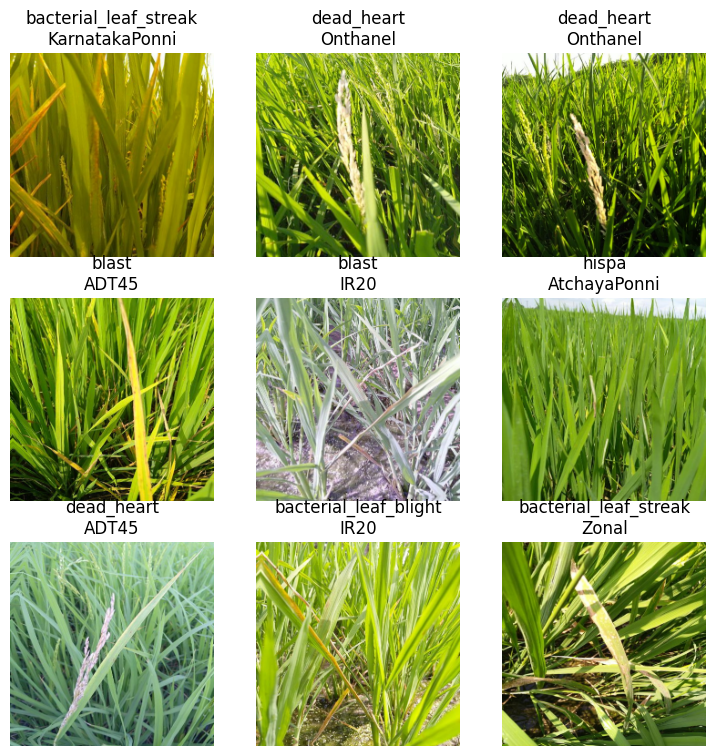

In [12]:
dls.show_batch()

All the stuff we did last time about messing around with multiple different heads and all that is actually totally unecessary. All we need to do when we create our `vision_learner` is tell it we don't want 10 outputs but we want 20 outputs.

Then you need to tell it what loss function to use:

In [13]:
orig_lf = CrossEntropyLossFlat()

def disease_err(inp, disease, variety): return error_rate(inp[:,:10], disease)
def variety_err(inp, disease, variety): return error_rate(inp[:,10:], variety)
def disease_loss(inp, disease, variety): return orig_lf(inp[:,:10], disease)
def variety_loss(inp, disease, variety): return orig_lf(inp[:,10:], variety)
def loss(pred, disease, variety): return orig_lf(pred[:,:10], disease)+orig_lf(pred[:,10:],variety)

In [14]:
err_metrics = (disease_err, variety_err)
all_metrics = err_metrics+(disease_loss, variety_loss)

In [15]:
arch = 'convnext_small_in22k'

In [16]:
learn = vision_learner(dls, arch, loss_func=loss, metrics=all_metrics, n_out=20).to_fp16()

Downloading: "https://dl.fbaipublicfiles.com/convnext/convnext_small_22k_224.pth" to /root/.cache/torch/hub/checkpoints/convnext_small_22k_224.pth


In [17]:
learn.fine_tune(12, 0.01) 

The final error rate for disease classification (~0.02) is similar to what I got with single-classification.

The fastai inference functions have options to decode the predictions, or to use the activation function. But since Jeremy defined a new loss function, you would need to add a softmax to the 20 outputs. You actually don't need to because for the Kaggle competition, we just needed which disease had the highest prediction, and whether it's softmax or not, it's going to be the same because that's a monotonic function. So it depends whether you actually needs probabilities or not.

But you only want to be looking at the first 10 for disease predictions:

```python
avg_pr = t_tta.mean(0)
avg_pr[:,:10].shape

idxs = avg_pr[:,:10].argmax(dim=1)
```

All the resnets and convnexts handle any input image size, it's only the transformer models that don't.

In my [next blog post](https://vishalbakshi.github.io/blog/posts/2024-02-05-paddy-part-7/) I work on improving my large ensemble predictions based on how Jeremy created his large ensemble.